In [79]:
import numpy as np
import matplotlib.pyplot as plt
import argparse
import os

from keras.models import Model
from keras.layers import Lambda, Input, Dense
from keras.losses import mse, binary_crossentropy
from keras.utils import plot_model
from keras import backend as K

In [80]:
def sampling(args):
    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    # by default, random_normal has mean=0 and std=1.0
    epsilon = K.random_normal(shape=(batch, dim))
    return z_mean + K.exp(0.5 * z_log_var) * epsilon

In [81]:
clip_scans_at = 8
# data = np.loadtxt("../../dataset/DIAG_first_floor.txt").astype('float32')
data = np.loadtxt("../../dataset/diag_underground.txt").astype('float32')
# data = np.loadtxt("../../dataset/diag_labrococo.txt").astype('float32')

In [83]:
ts = data[:, :7]
scans = data[:, 7:]
print(scans.shape, np.max(scans), np.min(scans))
np.clip(scans, a_min=0, a_max=clip_scans_at, out=scans)
      
bound = 0.15
min_bound = int(bound*scans.shape[1])
max_bound = int(scans.shape[1] - bound*scans.shape[1])
print("bounds", scans.shape, min_bound, max_bound)
scans = data[:, min_bound:max_bound] / clip_scans_at

print(scans.shape, np.max(scans), np.min(scans))

(13545, 721) 30.0 0.0
(13545, 721) 8.0 0.0
bounds (13545, 721) 108 612
(13545, 504) 1.0 0.089875


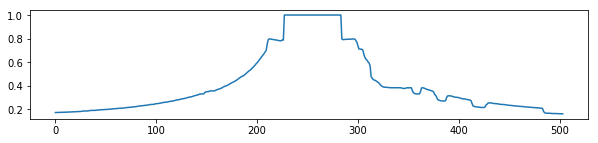

In [5]:
scan_idx = 25
plt.figure(figsize=(10, 2))
# plt.plot(np.arange(scans.shape[1]), scans[scan_idx,:])

In [6]:
split_data_at = .9
x_train = scans[:int(scans.shape[0]*split_data_at),:]
x_test = scans[int(scans.shape[0]*split_data_at):,:]
original_dim = scans.shape[1]

print("scans:", scans.shape)
print("xtrain:", x_train.shape)
print("xtest:", x_test.shape)

scans: (13545, 504)
xtrain: (12190, 504)
xtest: (1355, 504)


In [7]:
# network parameters
input_shape = (original_dim, )
intermediate_dim = 128
batch_size = 128
latent_dim = 10

# VAE model = encoder + decoder
# build encoder model
inputs = Input(shape=input_shape, name='encoder_input')
x = Dense(intermediate_dim, activation='relu')(inputs)
z_mean = Dense(latent_dim, name='z_mean')(x)
z_log_var = Dense(latent_dim, name='z_log_var')(x)

# use reparameterization trick to push the sampling out as input
# note that "output_shape" isn't necessary with the TensorFlow backend
z = Lambda(sampling, output_shape=(latent_dim,), name='z')([z_mean, z_log_var])

# instantiate encoder model
encoder = Model(inputs, [z_mean, z_log_var, z], name='encoder')
encoder.summary()
#plot_model(encoder, to_file='vae_mlp_encoder.png', show_shapes=True)

# build decoder model
latent_inputs = Input(shape=(latent_dim,), name='z_sampling')
x = Dense(intermediate_dim, activation='relu')(latent_inputs)
outputs = Dense(original_dim, activation='sigmoid')(x)

# instantiate decoder model
decoder = Model(latent_inputs, outputs, name='decoder')
# decoder.summary()

# instantiate VAE model
outputs = decoder(encoder(inputs)[2])
vae = Model(inputs, outputs, name='vae_mlp')

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      (None, 504)          0                                            
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 128)          64640       encoder_input[0][0]              
__________________________________________________________________________________________________
z_mean (Dense)                  (None, 10)           1290        dense_1[0][0]                    
__________________________________________________________________________________________________
z_log_var (Dense)               (None, 10)           1290        dense_1[0][0]                    
__________________________________________________________________________________________________
z (Lambda)

In [8]:
# models = (encoder, decoder)
# data = x_test
reconstruction_loss = binary_crossentropy(inputs, outputs)

In [9]:
reconstruction_loss *= original_dim
kl_loss = 1 + z_log_var - K.square(z_mean) - K.exp(z_log_var)
kl_loss = K.sum(kl_loss, axis=-1)
kl_loss *= -0.5
vae_loss = K.mean(reconstruction_loss + kl_loss)
vae.add_loss(vae_loss)
vae.compile(optimizer='adam')
# vae.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_input (InputLayer)   (None, 504)               0         
_________________________________________________________________
encoder (Model)              [(None, 10), (None, 10),  67220     
_________________________________________________________________
decoder (Model)              (None, 504)               66424     
Total params: 133,644
Trainable params: 133,644
Non-trainable params: 0
_________________________________________________________________


In [10]:
epochs = 50

vae.fit(x_train,
        epochs=epochs,
        batch_size=batch_size,
        verbose = 2,
        validation_data=(x_test, None))

Train on 12190 samples, validate on 1355 samples
Epoch 1/50
 - 1s - loss: 294.6852 - val_loss: 275.3016
Epoch 2/50
 - 0s - loss: 276.3161 - val_loss: 269.0838
Epoch 3/50
 - 0s - loss: 272.9354 - val_loss: 266.9677
Epoch 4/50
 - 0s - loss: 271.5605 - val_loss: 265.6543
Epoch 5/50
 - 0s - loss: 270.5854 - val_loss: 263.4027
Epoch 6/50
 - 0s - loss: 269.7590 - val_loss: 262.4627
Epoch 7/50
 - 0s - loss: 269.1040 - val_loss: 261.7675
Epoch 8/50
 - 0s - loss: 268.5706 - val_loss: 261.5644
Epoch 9/50
 - 0s - loss: 268.1811 - val_loss: 261.0059
Epoch 10/50
 - 0s - loss: 267.7991 - val_loss: 260.6684
Epoch 11/50
 - 0s - loss: 267.5220 - val_loss: 259.9887
Epoch 12/50
 - 0s - loss: 267.2776 - val_loss: 259.6432
Epoch 13/50
 - 0s - loss: 267.1899 - val_loss: 259.4804
Epoch 14/50
 - 0s - loss: 266.9391 - val_loss: 259.2941
Epoch 15/50
 - 0s - loss: 266.8527 - val_loss: 259.6906
Epoch 16/50
 - 0s - loss: 266.6752 - val_loss: 259.1955
Epoch 17/50
 - 0s - loss: 266.6073 - val_loss: 258.7261
Epoch 18

In [11]:
z_mean, _, _ = encoder.predict(x_test, batch_size=batch_size)
print(z_mean.shape)
x_decoded = decoder.predict(z_mean)
print(x_decoded.shape)

(1355, 10)
(1355, 504)


In [75]:
scan_idx = 900
lstep = (3/2)*np.pi/720
theta = np.arange(bound*(3/2)*np.pi, (1 - bound)*(3/2)*np.pi, lstep) - bound*(3/2)*np.pi
theta = theta[::-1]
print(theta.shape)

(504,)


In [73]:
def getScanSegments(scans, threshold):
    segments = []
    iseg = 0
    useg = bool(scans[0] > threshold)
    for d in range(scans.shape[0]):
        if useg and scans[d] < threshold:
            segments.append([iseg, d, useg])
            iseg = d
            useg = False
        if not useg and scans[d] > threshold:
            segments.append([iseg, d, useg])
            iseg = d
            useg = True
        if d == x.shape[0] - 1: segments.append([iseg, d, useg])
    return segments

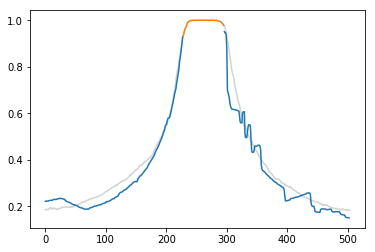

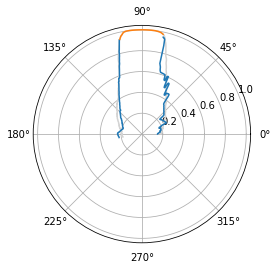

In [91]:
x = np.arange(x_test.shape[1])
segments = getScanSegments(x_test[scan_idx,:], 0.99)
# print(np.array(segments).shape, "--", segments)

plt.figure()
plt.plot(x, x_decoded[scan_idx,:], color='lightgray')
for s in segments:
    if s[2]: 
        col = '#ff7f0e'
        plt.plot(x[s[0]:s[1]], x_decoded[scan_idx, s[0]:s[1]], color=col)
    else:
        col = '#1f77b4'
        plt.plot(x[s[0]:s[1]], x_test[scan_idx, s[0]:s[1]], color=col)

plt.figure()
ax = plt.subplot(111, projection='polar')
ax.plot(theta, x_decoded[scan_idx, :], color='lightgray')
for s in segments:
    if s[2]: 
        col = '#ff7f0e'
        ax.plot(theta[s[0]:s[1]], x_decoded[scan_idx, s[0]:s[1]], color=col)
    else:
        col = '#1f77b4'
        ax.plot(theta[s[0]:s[1]], x_test[scan_idx, s[0]:s[1]], color=col)